In [1]:
import os
import sys
import pandas as pd
import numpy as np
import random
import time
import tensorflow as tf
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tonylab/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# Helper function
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()

In [3]:
def relu(x):
    return np.maximum(0,x)  

def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Load numpy array

In [4]:
all_npy = np.load('./npy/all_2372.npy')
movie_genre = np.load('./npy/movie_genre.npy')
usr_following = np.load('./npy/user_followings.npy')
usr_genre = np.load('./npy/user_genre.npy')

print('All features:', all_npy.shape)
print('Movie genre:', movie_genre.shape)
print('User following:', usr_following.shape)
print('User genre:', usr_genre.shape)

All features: (165, 2372)
Movie genre: (165, 20)
User following: (1582, 165)
User genre: (1582, 20)


In [5]:
usr_nb = len(usr_following) # the number of users
movie_nb = len(movie_genre)  # the number of movies
print(usr_nb, movie_nb)

# usr_test_amount = 150
# movie_test_amount = 32
# print(usr_test_amount, movie_test_amount)

latent_dim = 64 # latent dims
ft_dim = all_npy.shape[1] # feature dims
embedding_dims = 240
print(latent_dim, ft_dim, embedding_dims)

1582 165
64 2372 240


### Normalize usr_genre

In [6]:
usr_genre_norm = np.zeros(usr_genre.shape)
for i in range(len(usr_genre)):
    usr_genre_norm[i] = usr_genre[i]/np.max(usr_genre[i])
print(usr_genre_norm.shape)
# print('Before:', usr_genre)
# print('After:', usr_genre_norm)

(1582, 20)


# Training & testing split
## Prepare
### Movie

In [7]:
#The number of followers for each movie
moive_followers = np.sum(usr_following, axis=0)
# print(moive_followers)

print('Min number of followers:', np.min(moive_followers))
print('Max number of followers:', np.max(moive_followers))
print('Avg of followers:', np.mean(moive_followers))

asc = np.sort(moive_followers)
# print(asc)
desc = np.flip(asc)
# print(desc)

over5 = 0
for num in moive_followers:
    if num >= 5:
        over5 += 1
print('The num of followers over 5:', over5)

Min number of followers: 1
Max number of followers: 520
Avg of followers: 142.0969696969697
The num of followers over 5: 163


In [8]:
print('<= 10:', np.sum(moive_followers <= 10))
print('<= 20:', np.sum(moive_followers <= 20))
print('<= 30:', np.sum(moive_followers <= 30))
print('<= 40:', np.sum(moive_followers <= 40))
print('<= 50:', np.sum(moive_followers <= 50))
print('<= 100:', np.sum(moive_followers <= 100))
less_idx = np.nonzero(moive_followers <= 100)[0]
print(less_idx.shape, less_idx)

<= 10: 3
<= 20: 13
<= 30: 21
<= 40: 32
<= 50: 40
<= 100: 76
(76,) [  6   7   8  11  13  14  15  16  17  19  20  23  26  27  29  31  32  33
  35  36  38  39  41  43  45  46  47  48  51  54  56  59  61  63  65  67
  69  70  71  73  76  82  83  88  90  92  94  95  97  98 105 107 109 110
 113 115 116 117 124 130 132 133 135 136 138 139 140 145 146 148 150 155
 157 158 160 162]


In [9]:
print(usr_following.shape)
usr_following = usr_following.T
print(usr_following.shape)

(1582, 165)
(165, 1582)


In [10]:
st = set()
for idx in less_idx:
    print('Index:', idx)
    print('Sum:', usr_following[idx].sum())
#     print(usr_following[idx])
    li = list(np.where(usr_following[idx] == 1)[0])
#     print(li)
    st = st | set(li)
    print(len(st))
    print('==================================================')

Index: 6
Sum: 37
37
Index: 7
Sum: 1
38
Index: 8
Sum: 37
69
Index: 11
Sum: 75
141
Index: 13
Sum: 97
221
Index: 14
Sum: 23
235
Index: 15
Sum: 18
248
Index: 16
Sum: 31
269
Index: 17
Sum: 61
314
Index: 19
Sum: 78
357
Index: 20
Sum: 61
394
Index: 23
Sum: 72
433
Index: 26
Sum: 90
484
Index: 27
Sum: 23
497
Index: 29
Sum: 32
510
Index: 31
Sum: 58
532
Index: 32
Sum: 61
572
Index: 33
Sum: 80
624
Index: 35
Sum: 11
628
Index: 36
Sum: 78
652
Index: 38
Sum: 28
659
Index: 39
Sum: 49
677
Index: 41
Sum: 82
717
Index: 43
Sum: 70
743
Index: 45
Sum: 81
778
Index: 46
Sum: 77
810
Index: 47
Sum: 89
838
Index: 48
Sum: 49
849
Index: 51
Sum: 19
851
Index: 54
Sum: 18
854
Index: 56
Sum: 22
861
Index: 59
Sum: 24
864
Index: 61
Sum: 41
879
Index: 63
Sum: 58
893
Index: 65
Sum: 4
894
Index: 67
Sum: 76
903
Index: 69
Sum: 40
909
Index: 70
Sum: 41
922
Index: 71
Sum: 20
926
Index: 73
Sum: 43
931
Index: 76
Sum: 93
956
Index: 82
Sum: 78
987
Index: 83
Sum: 82
1003
Index: 88
Sum: 44
1007
Index: 90
Sum: 68
1015
Index: 92
Sum: 

In [11]:
test_idx = list(st)
test_idx.sort()
print(len(test_idx), test_idx[:10])

1185 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [12]:
usr_test_amount = len(test_idx)
movie_test_amount = len(less_idx)
print(usr_test_amount, movie_test_amount)

1185 76


In [13]:
usr_following = usr_following.T
print(usr_following.shape)

(1582, 165)


## Stat of user

In [14]:
coldarea = usr_following[test_idx, :][:, less_idx]
coldarea.shape

(1185, 76)

In [15]:
#The number of following movie for each user
each_user = np.sum(coldarea, axis=1)
# print(each_user)

print('Min number of followings:', np.min(each_user))
print('Max number of followings:', np.max(each_user))
print('Avg of followers:', np.mean(each_user))

asc = np.sort(each_user)
# print(each_user)
# print(asc)
desc = np.flip(asc)
# print(desc)

Min number of followings: 1
Max number of followings: 52
Avg of followers: 3.220253164556962


In [16]:
for i in range(1, 11):
    print('>=', i, ':', np.sum(each_user >= i))
# print('>', i, ':', np.sum(each_user > 10))

>= 1 : 1185
>= 2 : 831
>= 3 : 554
>= 4 : 377
>= 5 : 228
>= 6 : 161
>= 7 : 108
>= 8 : 76
>= 9 : 53
>= 10 : 39


In [17]:
new_test_idx = []
for i in test_idx:
    add = 0
    for j in less_idx:
        if usr_following[i][j] == 1:
            add += 1
            
    if add >= 6:
        new_test_idx.append(i)

In [18]:
len(new_test_idx)

161

In [19]:
random.seed(42)
test_idx = random.sample(new_test_idx, 100)
test_idx.sort()
print(len(test_idx), test_idx[:10])

100 [11, 21, 24, 30, 31, 43, 48, 52, 57, 71]


In [20]:
usr_test_amount = len(test_idx)
movie_test_amount = 32 #math.floor(len(less_idx)*0.5)
print(usr_test_amount, movie_test_amount)

100 32


## Setup 

In [21]:
# init
random.seed(42)
train_t = []
train_f = []
test_t = []
test_f = []

for i in test_idx:
    # init
    t_for_train = []
    f_for_train = []
    t_for_test = []
    f_for_test = []
    
    temp_t = []
    temp_f = []
    for j in less_idx:
        if usr_following[i][j] == 1:
            temp_t.append(j)
        else:
            temp_f.append(j)
            
    t_for_test = random.sample(temp_t, math.ceil(0.5*len(temp_t)))
    f_for_test = random.sample(temp_f, movie_test_amount-len(t_for_test))
    
    test_t.append(t_for_test)
    test_f.append(f_for_test)
    
    t_for_train = [item for item in temp_t if not item in t_for_test]
    f_for_train = [item for item in temp_f if not item in f_for_test]
    train_t.append(t_for_train)
    train_f.append(f_for_train)
    
    if not (len(t_for_train) + len(f_for_train) + len(t_for_test) + len(f_for_test)) == len(less_idx):
        print('Error!!!')
        break

In [22]:
print('The length of train_t:',len(train_t))
print('The length of train_f:',len(train_f))
print('The length of test_t:',len(test_t))
print('The length of test_f:',len(test_f))

The length of train_t: 100
The length of train_f: 100
The length of test_t: 100
The length of test_f: 100


## Stat

In [23]:
#average num of following for training user
total_train = 0
for t in train_t:
    total_train += len(t)
avg = total_train / usr_test_amount
print('Training:', avg)

#average num of following for testing user
total_test = 0
for t in test_t:
    total_test += len(t)
avg = total_test / usr_test_amount
print('Testing:', avg)

Training: 4.41
Testing: 4.82


In [24]:
all_auxilary = [i for i in range(movie_nb)]

# Recommendation model
## Training part

In [25]:
def training(SAVE_NAME):
    print('==================================================')
    print(SAVE_NAME)
    print('Start time:', time.ctime())

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    loss_acc_list = []
    t0 = time.time()

    train_yes_id=[]

    for q in range(6):
        print('Epoch:',q)
        train_auc = 0
        total_loss = 0
        xuij_auc = 0
        length = 0

        for z in range(usr_test_amount):
            writeProgress('Progress:', z, usr_test_amount)
            """
            yes 用來存放選擇到的YouTuber feature (for auxilary)
            yesr 用來存放user對該YouTuber的喜好程度(user_category 跟 YouTuber_category的相似性)
            r_3 用來存放user 對該YouTuber種類的偏好(取max)
            """
            yes = []
            yesr = []

    #         #選全部的Positive
    #         sample = random.sample(train_t[z],len(train_t[z]))
            #選全部的電影
            sample = all_auxilary

            #change
            r_3 = np.zeros(len(sample))

            for b in range(len(sample)):
                yes.append(all_npy[sample[b]])
                yesr.append(movie_genre[sample[b]] * usr_genre_norm[z])

            for b in range(len(yesr)):
                r_3[b]=max(yesr[b])
            #print('r_3:',r_3)

            yes = np.array(yes)

            # positive sample
            train_t_sample = train_t[z]
            for ta in train_t_sample:
                #print(ta,'--> positive feedback')

                pos = sample.index(ta)

                image_1 = np.expand_dims(all_npy[ta],0)
                train_f_sample = train_f[z] #random.sample(train_f[z],10)

                for b in train_f_sample:
                    image_2 = np.expand_dims(all_npy[b],0)

                    _last_be_relu, _norm_par, _a_list, r3, _auc, _loss, _ = sess.run(
                        [last_be_relu, norm_par, a_list_smooth, a_list_soft, auc, loss, train_op], 
                        feed_dict={user: [z], i: [ta], j: [b], xf: yes, 
                                   l_id:sample, l_id_len:[len(sample)],
                                   positive_id: train_t[z], positive_len:[len(train_t[z])],
                                   r: r_3, image_i: image_1, image_j: image_2})

                    '''Observe all params
                    print('u,vi,vj',_norm_par[:3])
                    print('w1,wu,wy,wa,wv',_norm_par[3:7])
                    print('beta',_norm_par[7])
                    print('Embedding',_norm_par[8])
                    print('after softmax:', r3)
                    print('before softmax:', _a_list)
                    print('---------------------------------------------------')
                    '''
                    train_auc += _auc
                    total_loss += _loss
                    length += 1

        print("{:<20}{}".format('total_loss', total_loss/length))
        print("{:<20}{}".format('train_auc:', train_auc/length))

        loss_acc_list.append([total_loss/length, train_auc/length])

        print('\tCurrent time:', time.ctime(), ' sec')
        print('==================================================')

    print('Total cost time:',time.time()-t0, ' sec')

    print('End time:', time.ctime())
    
    U, Y, A, E, Au, Ay, Aa, Av, B = sess.run([user_latent, item_latent, aux_item, embedding, Wu, Wy, Wa, Wv, Beta])
    np.savez('./weight/coldstart/' + SAVE_NAME + '.npz',
             U=U, Y=Y, A=A, E=E, Wu=Au, Wy=Ay, Wa=Aa, Wv=Av, B=B)
    
    return loss_acc_list

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
MRM_E240_movie
Start time: Thu May  7 12:50:55 2020
Epoch: 0
total_loss          [[0.24241042]]
train_auc:          0.9055189506135526
	Current time: Thu May  7 13:53:13 2020  sec
Epoch: 1
total_loss          [[0.04433526]]
train_auc:          0.9912954119567189
	Current time: Thu May  7 14:56:07 2020  sec
Epoch: 2
total_loss          [[0.01241636]]
train_auc:          0.9995768603034516
	Current time: Thu May  7 15:58:57 2020  sec
Epoch: 3
total_loss          [[0.0065547]]
train_auc:          0.9998791029438433
	Current time: Thu May  7 17:01:31 2020  sec
Epoch: 4
total_loss          [[0.

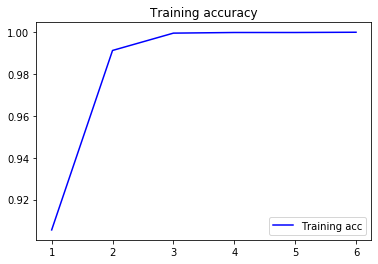

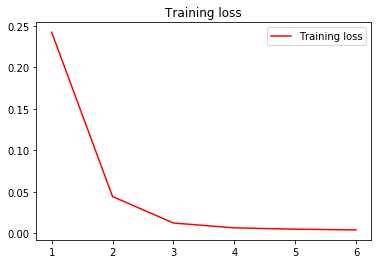

In [26]:
SAVE_NAME = 'MRM_E{}_{}'.format(embedding_dims, "movie")

tf.reset_default_graph()

user = tf.placeholder(tf.int32,shape=(1,))
i = tf.placeholder(tf.int32, shape=(1,))
j = tf.placeholder(tf.int32, shape=(1,))

#多少個auxliary 
xf = tf.placeholder(tf.float32, shape=(None, ft_dim))
l_id = tf.placeholder(tf.int32, shape=(None,))
l_id_len = tf.placeholder(tf.int32,shape=(1,))
r = tf.placeholder(tf.float32,shape=(None,))
positive_id = tf.placeholder(tf.int32, shape=(None,))
positive_len = tf.placeholder(tf.int32,shape=(1,))

image_i = tf.placeholder(tf.float32, [1, ft_dim])
image_j = tf.placeholder(tf.float32, [1, ft_dim])

with tf.variable_scope("item_level"):
    user_latent = tf.get_variable("user_latent", [usr_nb, latent_dim],
                                  initializer=tf.random_normal_initializer(0,0.1,seed=8))
    item_latent = tf.get_variable("item_latent", [movie_nb, latent_dim],
                                  initializer=tf.random_normal_initializer(0,0.1,seed=9)) 
    aux_item = tf.get_variable("aux_item", [movie_nb, latent_dim],
                               initializer=tf.random_normal_initializer(0,0.1,seed=10))

#     W1 = tf.get_variable("W1", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wu = tf.get_variable("Wu", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wy = tf.get_variable("Wy", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wa = tf.get_variable("Wa", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wv = tf.get_variable("Wv", [usr_nb, movie_nb, embedding_dims], initializer=tf.contrib.layers.xavier_initializer())
#     Wve = tf.get_variable("Wve", [embedding_dims, ft_dim], initializer=tf.contrib.layers.xavier_initializer())

    aux_new = tf.get_variable("aux_new", [1, latent_dim], initializer=tf.constant_initializer(0.0))

with tf.variable_scope('feature_level'):
    embedding = tf.get_variable("embedding", [embedding_dims,ft_dim],
                                initializer=tf.contrib.layers.xavier_initializer())
    Beta = tf.get_variable("beta", [usr_nb, embedding_dims],
                           initializer=tf.random_normal_initializer(0.01, 0.001, seed=10))

#lookup the latent factors by user and id
u = tf.nn.embedding_lookup(user_latent, user)
vi = tf.nn.embedding_lookup(item_latent, i)
vj = tf.nn.embedding_lookup(item_latent, j)

# w1 = tf.nn.embedding_lookup(W1, user)
wu = tf.squeeze(tf.nn.embedding_lookup(Wu, user))
wy = tf.squeeze(tf.nn.embedding_lookup(Wy, user))
wa = tf.squeeze(tf.nn.embedding_lookup(Wa, user))
wv = tf.squeeze(tf.nn.embedding_lookup(Wv, user))

beta = tf.nn.embedding_lookup(Beta, user) #user feature latent factor

a_list = tf.Variable([])
q = tf.constant(0)

def att_cond(q,a_list):
    return tf.less(q,l_id_len[0])

def att_body(q,a_list):
    xfi = tf.expand_dims(xf[q],0) #(1,l)
    wuui = tf.expand_dims(tf.nn.embedding_lookup(wu,l_id[q]),0) #取該YOUTUBER那欄(1,K)
    wyui = tf.expand_dims(tf.nn.embedding_lookup(wy,l_id[q]),0) #取該YOUTUBER那欄(1,K)
    waui = tf.expand_dims(tf.nn.embedding_lookup(wa,l_id[q]),0) #取該YOUTUBER那欄(1,K)
    wvui = tf.expand_dims(tf.nn.embedding_lookup(wv,l_id[q]),0) #取該YOUTUBER那欄(1,K)

    a_list = tf.concat([a_list,[(tf.nn.relu(tf.matmul(wuui, u, transpose_b=True) +
                                            tf.matmul(wyui, tf.expand_dims(tf.nn.embedding_lookup(item_latent,l_id[q]),0), transpose_b=True) +
                                            tf.matmul(waui, tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[q]),0), transpose_b=True) +
                                            tf.matmul(wvui, tf.matmul(embedding,xfi, transpose_b=True)))[0][0])*r[q]]],0)
    q += 1
    return q, a_list

_, a_list = tf.while_loop(att_cond,att_body,[q,a_list],shape_invariants=[q.get_shape(),tf.TensorShape([None])])

a_list_smooth = tf.add(a_list,0.0000000001)
a_list_soft = tf.divide(a_list_smooth,tf.reduce_sum(a_list_smooth, 0)) #without softmax

norm_par = [wu,wy,wa,wv]

wuui = tf.expand_dims(tf.nn.embedding_lookup(wu,l_id[-1]),0)
wyui = tf.expand_dims(tf.nn.embedding_lookup(wy,l_id[-1]),0)
waui = tf.expand_dims(tf.nn.embedding_lookup(wa,l_id[-1]),0)
wvui = tf.expand_dims(tf.nn.embedding_lookup(wv,l_id[-1]),0)
wu_be_relu = tf.matmul(wuui, u, transpose_b=True)
wy_be_relu = tf.matmul(wyui, tf.expand_dims(tf.nn.embedding_lookup(item_latent,l_id[-1]),0), transpose_b=True)
wa_be_relu = tf.matmul(waui, tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[-1]),0), transpose_b=True)
wv_be_relu = tf.matmul(wvui, tf.matmul(embedding,tf.expand_dims(xf[-1],0), transpose_b=True))

last_be_relu = [wu_be_relu,wy_be_relu,wa_be_relu,wv_be_relu]

aux_np = tf.expand_dims(tf.zeros(latent_dim),0)
q = tf.constant(0)

def sum_att_cond(q,aux_np):
    return tf.less(q,l_id_len[0])

def sum_att_body(q,aux_np):
    aux_np = tf.math.add_n([aux_np,a_list_soft[q]*tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[q]),0)]) 
    q += 1
    return q, aux_np

_, aux_np = tf.while_loop(sum_att_cond, sum_att_body, [q,aux_np])

aux_part = tf.matmul(aux_np, vi, transpose_b=True)
aux_np += u #user_latent factor + sum (alpha*auxilary)
aux_new = tf.assign(aux_new,aux_np) #把aux_new 的 值變成aux_np

latent_i_part = tf.matmul(aux_new, vi, transpose_b=True)
feature_i_part = tf.matmul(beta,(tf.matmul(embedding,image_i, transpose_b=True)))
latent_j_part = tf.matmul(aux_new, vj, transpose_b=True)
feature_j_part = tf.matmul(beta,(tf.matmul(embedding,image_j, transpose_b=True)))
only_aux_i_part = tf.matmul(aux_np, vi, transpose_b=True)
only_aux_j_part = tf.matmul(aux_np, vj, transpose_b=True)

#矩陣中對應函數各自相乘
# ex: tf.matmul(thetav,(tf.matmul(embedding, image_i, transpose_b=True)))
xui = tf.matmul(aux_new, vi, transpose_b=True)+ tf.matmul(beta,(tf.matmul(embedding,image_i, transpose_b=True)))
xuj = tf.matmul(aux_new, vj, transpose_b=True)+ tf.matmul(beta,(tf.matmul(embedding,image_j, transpose_b=True)))

xuij = tf.subtract(xui,xuj)

l2_norm = tf.add_n([
            0.0001 * tf.reduce_sum(tf.multiply(u, u)),
            0.0001 * tf.reduce_sum(tf.multiply(vi, vi)),
            0.0001 * tf.reduce_sum(tf.multiply(vj, vj)),

            0.01 * tf.reduce_sum(tf.multiply(wu, wu)),
            0.01 * tf.reduce_sum(tf.multiply(wy, wy)),
            0.01 * tf.reduce_sum(tf.multiply(wa, wa)),
            0.00001 * tf.reduce_sum(tf.multiply(wv,wv)),

            0.001 * tf.reduce_sum(tf.multiply(beta,beta)),
            0.00001 * tf.reduce_sum(tf.multiply(embedding,embedding))
          ])

loss = l2_norm - tf.log(tf.sigmoid(xuij)) # objective funtion
train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss) #parameter optimize 
auc = tf.reduce_mean(tf.to_float(xuij > 0))

loss_acc_list = training(SAVE_NAME)

# training history
epochs = range(1, len(loss_acc_list) + 1)
print('Epoch:', epochs)
loss = [ls[0].tolist()[0][0] for ls in loss_acc_list]
print('Loss:', loss)
acc = [ls[1] for ls in loss_acc_list]
print('Acc:', acc)
print('==================================================')

plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Testing Part

# Metrics

## Top N

In [27]:
def F1_score(prec,rec):
    f1 = 2*((prec*rec)/(prec+rec))
    return f1

def topN(RSls, n):
    maxn = np.argsort(RSls)[::-1][:n]
    return maxn

## NDCG

In [28]:
def allSortPrepare(testRS):
    all_sort = []

    for i in range(usr_test_amount):
        all_sort.append(topN(list(testRS[i]),len(testRS[i])))

    all_sort = np.asarray(all_sort)
    print(all_sort.shape)
    return all_sort

In [29]:
def DCG(prec_list): #找出前n名的[1,1,1,0,...]
    dcg = 0
    for i in range(len(prec_list)):
        dcg += (2**prec_list[i]-1)/math.log2(i+2)
    return dcg

def NDCG(target, testRS, num_ndcg, all_sort): #target是真正的喜好
    total_ndcg = 0
    
    for m in range(usr_test_amount): # the number of testing users
        idcg = DCG(target[m][:num_ndcg])
        
        pre_list = []
        for s in all_sort[m][:num_ndcg]:
            #print(m,s,target[m][s])
            pre_list.append(target[m][s]) #把prec_list 的 score加進去
        
        dcg = DCG(pre_list)
        ndcg = dcg/idcg
        total_ndcg += ndcg
        
    avg_ndcg = total_ndcg/usr_test_amount
    return avg_ndcg

## MAP

In [30]:
from sklearn.metrics import average_precision_score

def MAP(target,testRS):
    total_prec = 0
    for u in range(usr_test_amount):
        y_true = target[u]
        y_scores = testRS[u]
        total_prec += average_precision_score(y_true, y_scores)
        
    Map_value = total_prec/usr_test_amount
    
    return Map_value

In [31]:
def metrics(testRS, target, sumtarget, all_sort):
    print('\n==============================\n')
    # Top N
    N = [1, 5]
    correct = 0

    for n in N:
        print('Top', n)
        correct = 0

        for i in range(len(testRS)):
            topn = topN(testRS[i], n)
            sum_target = int(np.sum(target[i]))

            TP = 0
            for i in topn:
                if i < sum_target:
                    TP += 1

            correct += TP

        prec = correct/(len(testRS)*n) #150*n
        recall = correct/sumtarget

        print('prec:', prec)
        print('recall:', recall)
        print('F1_score:', F1_score(prec, recall))
        print('*****')

    print('\n==============================\n')

    # NDCG
    num_ndcgs = [5, 10]
    for num_ndcg in num_ndcgs:
        print('NDCG@', num_ndcg)
        print('NDCG score:', NDCG(target, testRS, num_ndcg, all_sort))
        print('*****')

    print('\n==============================\n')

    # MAP
    print('MAP:', MAP(target,testRS))
    print('\n==============================\n')

In [32]:
def testing(U, Y, A, E, Au, Ay, Aa, Av, B):
    #with Embedding
    result = np.zeros((usr_test_amount, movie_nb))
    RS = np.zeros((usr_test_amount, movie_nb))

    #test_idx --> Test 的 index length = 150
    sum_alpha = 0
    test_yes_id = []

    for s in range(usr_test_amount):
#         print(s, test_idx[s])
        
        yes = []
        sample = [i for i in range(movie_nb)]
        alpha = np.zeros([len(sample)])
        
        for a in range(len(sample)):
            r = np.max(movie_genre[sample[a]] * usr_genre_norm[test_idx[s]]) #sample a 的category vec *user_category vec

    # #         ''' Observe each part in attention
    #         WuUu = np.sum(np.dot(Au[test_idx[s]],np.expand_dims(U[test_idx[s]],0).T))
    #         WyYy = np.sum(np.dot(Ay[sample[a]],np.expand_dims(Y[sample[a]],0).T))
    #         WaAa = np.sum(np.dot(Aa[test_idx[s]],np.expand_dims(A[sample[a]],0).T))
    #         WvVy = np.sum(np.dot(np.dot(Av[test_idx[s]], E),np.expand_dims(all_npy[sample[a]],0).T))
    #         print('The sum of each par -->',
    #               '\nw1:',testW1,
    #               '\nWuU:',WuUu,
    #               '\nwyY:',WyYy,
    #               '\nWaA:',WaAa,
    #               '\nWvV:',WvVy)
    # #         '''

            alpha_a = (np.dot(Au[test_idx[s]][sample[a]],np.expand_dims(U[test_idx[s]],0).T) + 
                       np.dot(Ay[test_idx[s]][sample[a]],np.expand_dims(Y[sample[a]],0).T) + 
                       np.dot(Aa[test_idx[s]][sample[a]],np.expand_dims(A[sample[a]],0).T) +
                       np.dot(Av[test_idx[s]][sample[a]],np.dot(E,np.expand_dims(all_npy[sample[a]],0).T)))


            # relu part
            alpha[a]=np.sum((relu(alpha_a)))*r
            # tanh part
    #         alpha[a]=np.sum((np.tanh(alpha_a)))*r

        mul = np.zeros((1,latent_dim))
        added_alpha = np.add(alpha,0.0000000001)
        norm_alpha = added_alpha/np.sum(added_alpha)
        sum_alpha += np.sum(alpha)

#         print("{:<15}{}".format('sum_alpha:', sum_alpha))
#         print('==================================================')

        for i in range(len(sample)):
            mul += norm_alpha[i] * A[sample[i]] # attention alpha*Ai part
        new_mul = mul + U[test_idx[s]]  #(U+auxilary)

        for k in range(movie_test_amount):
            result[s][k] = np.dot(new_mul,Y[k].T) #(U+auxilary)*photo latent factor
            RS[s][k] = np.dot(new_mul,Y[k].T) + np.dot(B[test_idx[s]], np.dot(E, all_npy[k].T))
        
    #取出test的資料
    print(RS.shape)

    testRS = np.zeros((usr_test_amount, movie_test_amount)) #shape 150 * 32
    target = np.zeros((usr_test_amount, movie_test_amount)) #shape 150 * 32

    for z in range(usr_test_amount):
        user_id = test_idx[z]
        # positive target YouTuber list
        youtube_t = test_t[z] 
        # not target YouTuber list
        youtube_f = test_f[z]

#         print(user_id)
#         print(youtube_t)
#         print(youtube_f)

        #前面放target的RS
        for i in range(len(youtube_t)):
            testRS[z][i] = RS[z][youtube_t[i]]
            target[z][i] = 1

        for i in range(len(youtube_f)):
            testRS[z][i+len(youtube_t)] = RS[z][youtube_f[i]]

    #     print(testRS[z])
    #     print(target[z])
    #     print('==============================')

    print(target.shape, testRS.shape)
    sumtarget = np.sum(target)
    print('num of positive data in testing:', sumtarget) # whole matrix: 4800

    # for metrics
    metrics(testRS, target, sumtarget, allSortPrepare(testRS))

# Evaluate weight

In [36]:
SAVE_NAME = 'MRM_E240_movie_<=100_32_100'

In [37]:
SAVE_FILE = './weight/coldstart/' + SAVE_NAME + '.npz'

# Get latent factor and Each weight

In [38]:
print(SAVE_NAME)

params = np.load(SAVE_FILE)

U = params['U']
Y = params['Y']
A = params['A']
E = params['E']
Au = params['Wu']
Ay = params['Wy']
Aa = params['Wa']
Av = params['Wv']
B = params['B']

print('User latent shape: ',U.shape)
print('photo latent shape: ', Y.shape)
print('Auxilary latent shape: ',A.shape)
print('Embedding shape:', E.shape)
print('Wu weight shape:', Au.shape)
print('Wy weight shape:', Ay.shape)
print('Wa weight shape:', Aa.shape)
print('Wv weight shape:', Av.shape)
print('Beta shape:',B.shape)

testing(U, Y, A, E, Au, Ay, Aa, Av, B)
print('==================================================')

MRM_E240_movie_<=100_32_100
User latent shape:  (1582, 64)
photo latent shape:  (165, 64)
Auxilary latent shape:  (165, 64)
Embedding shape: (240, 2372)
Wu weight shape: (1582, 165, 64)
Wy weight shape: (1582, 165, 64)
Wa weight shape: (1582, 165, 64)
Wv weight shape: (1582, 165, 240)
Beta shape: (1582, 240)
(100, 165)
(100, 32) (100, 32)
num of positive data in testing: 482.0
(100, 32)


Top 1
prec: 0.02
recall: 0.004149377593360996
F1_score: 0.006872852233676976
*****
Top 5
prec: 0.408
recall: 0.42323651452282157
F1_score: 0.41547861507128303
*****


NDCG@ 5
NDCG score: 0.3562973377804742
*****
NDCG@ 10
NDCG score: 0.39045624699467774
*****


MAP: 0.1566400499466107


